#### **1) Libraries**

In [1]:
# !pip install -U tensorflow_probability -q
!pip install -q ipdb

In [2]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import time
from tqdm import tqdm

If using Google Colab, save in your Google Drive.

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### **2) MNIST Data**

In [4]:
import tensorflow as tf

In [5]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [6]:
def preprocess_images(images, image_size, batch_size, nn_type):
    if nn_type == 'conv':
        images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
    else:
        images = images.reshape((images.shape[0], -1)) / 255.
    images = np.where(images > .5, 1.0, 0.0).astype('float32')
    return (tf.data.Dataset.from_tensor_slices(images)
            .shuffle(image_size).batch(batch_size))

In [7]:
train_size = 60000
test_size = 10000
batch_size = 64

In [8]:
train_images.shape, test_images.shape

((60000, 28, 28), (10000, 28, 28))

In [9]:
# Use CNN
train_dataset = preprocess_images(train_images, train_size, batch_size, 'conv')
test_dataset = preprocess_images(test_images, test_size, batch_size, 'conv')
# Use Dense
# X_train = X_train_images.reshape((train_size, -1)).astype('float32')
# X_test = X_test_images.reshape((test_size, -1)).astype('float32')

In [10]:
print(train_dataset), print(test_dataset)
# X_train.shape, X_test.shape

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>
<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>


(None, None)

#### **3) Model Class**

Credit: [6 different ways of implementing VAE with TF2 and TFP](https://towardsdatascience.com/6-different-ways-of-implementing-vae-with-tensorflow-2-and-tensorflow-probability-9fe34a8ab981) (version f)

In [11]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras.layers import Input, InputLayer, Lambda, Reshape, Dropout, \
                                    Flatten, Dense, Conv2D, Conv2DTranspose 

In [12]:
class Sampler_Z(keras.layers.Layer):

    def call(self, inputs):
        mu, rho = inputs
        sd = tf.math.log(1+tf.math.exp(rho))
        batch_size = tf.shape(mu)[0]
        dim_z = tf.shape(mu)[1]
        z_sample = mu + sd * tf.random.normal(shape=(batch_size, dim_z))
        return z_sample, sd

In [13]:
class Encoder_Z(keras.layers.Layer):

    def __init__(self, dim_z, name="encoder", **kwargs):
        super(Encoder_Z, self).__init__(name=name, **kwargs)
        self.dim_x = (28, 28, 1)
        self.dim_z = dim_z
        self.conv_layer_1 = Conv2D(filters=32, kernel_size=3, strides=(2,2), 
                                   padding='valid', activation='relu'
                                   )
        self.conv_layer_2 = Conv2D(filters=64, kernel_size=3, strides=(2,2), 
                                    padding='valid', activation='relu'
                                    )
        self.flatten_layer = Flatten()
        self.dense_mean = Dense(self.dim_z, activation=None, name='z_mean')
        self.dense_raw_stddev = Dense(self.dim_z, activation=None,
                                      name='z_raw_stddev'
                                      )
        self.sampler_z = Sampler_Z()

    # Functional
    def call(self, x_input):
        z = self.conv_layer_1(x_input)
        z = self.conv_layer_2(z)
        z = self.flatten_layer(z)
        mu = self.dense_mean(z)
        rho = self.dense_raw_stddev(z)
        z_sample, sd = self.sampler_z((mu,rho))
        return z_sample, mu, sd

In [14]:
class Decoder_X(keras.layers.Layer):

    def __init__(self, dim_z, name="decoder", **kwargs):
        super(Decoder_X, self).__init__(name=name, **kwargs)
        self.dim_z = dim_z
        self.dense_z_input = Dense(7*7*32, activation=None)
        self.reshape_layer = Reshape((7,7,32))
        self.conv_transpose_layer_1 = Conv2DTranspose(filters=64, kernel_size=3, strides=2, 
                                                      padding='same', activation='relu'
                                                      )
        self.conv_transpose_layer_2 = Conv2DTranspose(filters=32, kernel_size=3, strides=2, 
                                                      padding='same', activation='relu'
                                                      )
        self.conv_transpose_layer_3 = Conv2DTranspose(filters=1, kernel_size=3, strides=1, 
                                                      padding='same'
                                                      )

    # Functional
    def call(self, z):
        x_output = self.dense_z_input(z)
        x_output = self.reshape_layer(x_output)
        x_output = self.conv_transpose_layer_1(x_output)
        x_output = self.conv_transpose_layer_2(x_output)
        x_output = self.conv_transpose_layer_3(x_output)
        return x_output

In [15]:
class VAEModel(keras.Model):
    """Variational Autoencoder base model."""

    def __init__(self, dim_z, learning_rate=0.0005, kl_weight=1, name="autoencoder", **kwargs):
        super(VAEModel, self).__init__(name=name, **kwargs)
        self.dim_x = (28, 28, 1)
        self.dim_z = dim_z
        self.learning_rate = learning_rate
        self.encoder = Encoder_Z(dim_z=self.dim_z)
        self.decoder = Decoder_X(dim_z=self.dim_z)
        self.kl_weight = kl_weight

    # def encode_and_decode(self, x_input):
    def call(self, x_input):
        z_sample, mu, sd = self.encoder(x_input)
        x_recons_logits = self.decoder(z_sample)
        
        kl_divergence = - 0.5 * tf.math.reduce_sum(1 + \
                                                   tf.math.log(tf.math.square(sd)) - \
                                                   tf.math.square(mu) - \
                                                   tf.math.square(sd), axis=1
                                                   )
        kl_divergence = tf.math.reduce_mean(kl_divergence)
        # self.add_loss(lambda: self.kl_weight * kl_divergence)
        self.add_loss(self.kl_weight * kl_divergence)
        return x_recons_logits

In [20]:
class VAE:
    """Variational Autoencoder wrapper class."""
    # def __init__(self, n_hidden, latent_dim, dropout=0.):
    def __init__(self, dim_z, learning_rate=0.0005):
        self.optimizer = keras.optimizers.Adam(1e-4)
        # self.optimizer = keras.optimizers.Adam(learning_rate)
        self.loss_metric = keras.metrics.Mean()
        self.model = VAEModel(dim_z)
        # self.model = VAEModel(n_hidden, latent_dim, dropout)

    def train(self, train_dataset, test_dataset, epochs=100, batch_size=0, show_display=True):
        # Pick a sample of the test set for generating output images
        num_examples_to_generate = 16
        assert batch_size >= num_examples_to_generate
        for test_batch in test_dataset.take(1):
            test_sample = test_batch[0:num_examples_to_generate, :, :, :]

        for epoch in range(epochs):
            start_time = time.time()
            for train_x in tqdm(train_dataset):
                self.train_step(train_x, self.optimizer, self.loss_metric)
            end_time = time.time()
            elbo = -self.loss_metric.result()
            #display.clear_output(wait=False)
            print('Epoch: {}, Train set ELBO: {}, time elapse for current epoch: {}'.format(
                    epoch, elbo, end_time - start_time)
            )
            # generate_images(vae, test_sample)
            self.generate_and_save_images(epoch, test_sample)
        '''
        # Pick a sample of the test set for generating output images
        num_examples_to_generate = 16
        assert batch_size >= num_examples_to_generate
        for test_batch in test_dataset.take(1):
            test_sample = test_batch[0:num_examples_to_generate, :, :, :]

        for epoch in range(1, epochs + 1):
            # ipdb.set_trace()
            start_time = time.time()
            for train_x in train_dataset:
                self.train_step(train_x)
            end_time = time.time()

            loss = tf.keras.metrics.Mean()
            for test_x in test_dataset:
                loss(self._compute_loss(test_x))
            elbo = -loss.result()
            display.clear_output(wait=False)
            print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
                    .format(epoch, elbo, end_time - start_time))
            if show_display:
                self.generate_and_save_images(epoch, test_sample)
        '''

    @tf.function
    def train_step(self, x_true, optimizer, loss_metric):
        with tf.GradientTape() as tape:
            neg_log_lik = self.partial_vae_loss(x_true)
            # kl_loss = model.losses[-1]
            kl_loss = tf.math.reduce_sum(self.model.losses)  # vae.losses is a list
            total_vae_loss = neg_log_lik + kl_loss
        gradients = tape.gradient(total_vae_loss, self.model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        loss_metric(total_vae_loss)

    # vae loss function -- only the negative log-likelihood part, 
    # since we use add_loss for the KL divergence part
    def partial_vae_loss(self, x_true):
        # x_recons_logits = model.encode_and_decode(x_true)
        x_recons_logits = self.model(x_true)
        # compute cross entropy loss for each dimension of every datapoint
        raw_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
        labels=x_true, logits=x_recons_logits)
        neg_log_likelihood = tf.math.reduce_sum(raw_cross_entropy, axis=[1, 2, 3])
        return tf.math.reduce_mean(neg_log_likelihood)

    def generate_and_save_images(self, epoch, test_sample):
        z_sample, _, _ = self.model.encoder(test_sample)
        predictions = self.model.decoder(z_sample)
        # mean, logvar = self.model.encode(test_sample)
        # z = self.model.reparameterize(mean, logvar)
        # predictions = self.model.sample(z)
        fig = plt.figure(figsize=(4, 4))

        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i + 1)
            plt.imshow(predictions[i, :, :, 0], cmap='gray')
            plt.axis('off')

        # tight_layout minimizes the overlap between 2 sub-plots
        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
        plt.show()


#### **4) Models Train**

In [21]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
z_dim = 4  # 2
batch_size = 32
num_examples_to_generate = 16
learning_rate = 0.0005

In [22]:
vae = VAE(z_dim, learning_rate)

100%|██████████| 938/938 [00:03<00:00, 251.83it/s]


Epoch: 0, Train set ELBO: -243.08030700683594, time elapse for current epoch: 3.7271783351898193


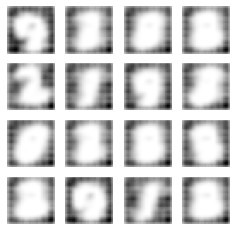

100%|██████████| 938/938 [00:02<00:00, 328.18it/s]


Epoch: 1, Train set ELBO: -204.232421875, time elapse for current epoch: 2.860659599304199


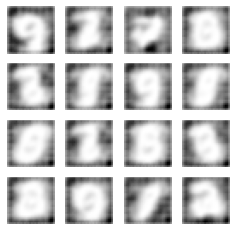

100%|██████████| 938/938 [00:02<00:00, 329.47it/s]


Epoch: 2, Train set ELBO: -187.09384155273438, time elapse for current epoch: 2.8495569229125977


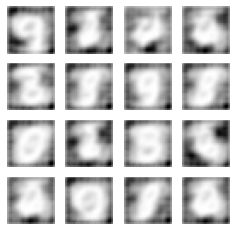

100%|██████████| 938/938 [00:02<00:00, 330.89it/s]


Epoch: 3, Train set ELBO: -177.00889587402344, time elapse for current epoch: 2.837552070617676


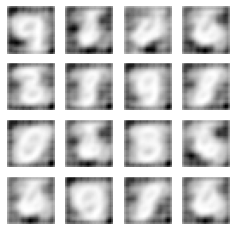

100%|██████████| 938/938 [00:02<00:00, 329.62it/s]


Epoch: 4, Train set ELBO: -170.368408203125, time elapse for current epoch: 2.8484132289886475


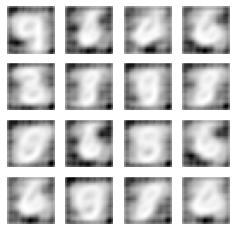

100%|██████████| 938/938 [00:02<00:00, 329.13it/s]


Epoch: 5, Train set ELBO: -165.60935974121094, time elapse for current epoch: 2.852613687515259


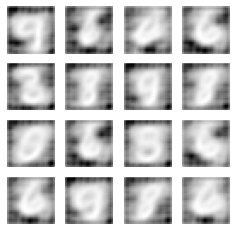

100%|██████████| 938/938 [00:02<00:00, 327.38it/s]


Epoch: 6, Train set ELBO: -161.9720916748047, time elapse for current epoch: 2.868197441101074


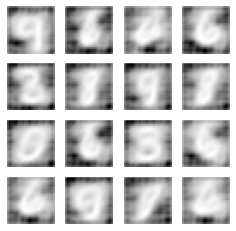

100%|██████████| 938/938 [00:02<00:00, 328.06it/s]


Epoch: 7, Train set ELBO: -159.055908203125, time elapse for current epoch: 2.8619227409362793


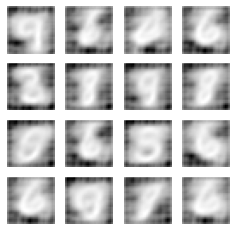

100%|██████████| 938/938 [00:02<00:00, 328.82it/s]


Epoch: 8, Train set ELBO: -156.6312255859375, time elapse for current epoch: 2.8554837703704834


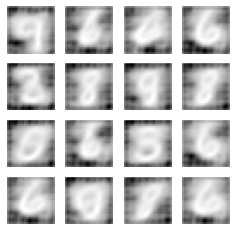

100%|██████████| 938/938 [00:02<00:00, 328.97it/s]


Epoch: 9, Train set ELBO: -154.56253051757812, time elapse for current epoch: 2.856860637664795


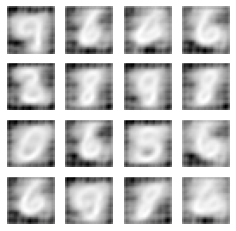

In [23]:
vae.train(train_dataset, test_dataset, epochs, batch_size)